## Scott Breitbach
### DSC530: Week 8
### Assignment 8.2
### 20-October-2020

# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [206]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

## Hypothesis testing

The following is a version of `thinkstats2.HypothesisTest` with just the essential methods:

In [207]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

And here's an example that uses it to compute the p-value of an experiment where we toss a coin 250 times and get 140 heads.

In [208]:
class CoinTest(HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

The p-value turns out to be about 7%, which is considered on the border of statistical significance.

In [209]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.064

## Permutation test

To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups and generate simulated results by shuffling the data.

In [210]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Here's an example where we test the observed difference in pregnancy length for first babies and others.

In [211]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

The p-value is about 17%, which means it is plausible that the observed difference is just the result of random sampling, and might not be generally true in the population.

In [212]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.147

Here's the distrubution of the test statistic (the difference in means) over many simulated samples:

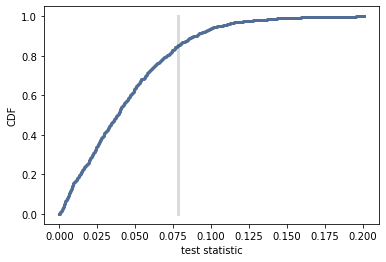

In [213]:
ht.PlotCdf()
thinkplot.Config(xlabel='test statistic',
                   ylabel='CDF')

Under the null hypothesis, we often see differences bigger than the observed difference.

In [214]:
class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

If the hypothesis under test is that first babies come late, the appropriate test statistic is the raw difference between first babies and others, rather than the absolute value of the difference.  In that case, the p-value is smaller, because we are testing a more specific hypothesis.

In [215]:
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue

0.081

But in this example, the result is still not statistically significant.

## Difference in standard deviation

In this framework, it is easy to use other test statistics.  For example, if we think the variance for first babies might be higher, we can run this test:

In [216]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [217]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.1

But that's not statistically significant either.

## Testing correlation

To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

In [218]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

Here's an example testing the correlation between birth weight and mother's age.

In [219]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

The reported p-value is 0, which means that in 1000 trials we didn't see a correlation, under the null hypothesis, that exceeded the observed correlation.  That means that the p-value is probably smaller than $1/1000$, but it is not actually 0.

To get a sense of how unexpected the observed value is under the null hypothesis, we can compare the actual correlation to the largest value we saw in the simulations.

In [220]:
ht.actual, ht.MaxTestStat()

(0.0688339703541091, 0.036523685619501235)

## Testing proportions

Here's an example that tests whether the outcome of a rolling a six-sided die is suspicious, where the test statistic is the total absolute difference between the observed outcomes and the expected long-term averages.

In [221]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

Here's an example using the data from the book:

In [222]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.1297

The observed deviance from the expected values is not statistically significant.

By convention, it is more common to test data like this using the chi-squared statistic:

In [223]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

Using this test, we get a smaller p-value:

In [224]:
dt = DiceChiTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.0433

Taking this result at face value, we might consider the data statistically significant, but considering the results of both tests, I would not draw any strong conclusions.

## Chi-square test of pregnancy length

In [225]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

If we specifically test the deviations of first babies and others from the expected number of births in each week of pregnancy, the results are statistically significant with a very small p-value.  But at this point we have run so many tests, we should not be surprised to find at least one that seems significant.

In [226]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 28.65693232552233


## Power

Here's the function that estimates the probability of a non-significant p-value even is there really is a difference between the groups.

In [227]:
def FalseNegRate(data, num_runs=1000):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [228]:
neg_rate = FalseNegRate(data)
neg_rate

0.709

In this example, the false negative rate is 70%, which means that the power of the test (probability of statistical significance if the actual difference is 0.078 weeks) is only 30%.

## Exercises

### Exercise 9-1

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [229]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

print("Original sample size:", len(live))

Original sample size: 9148


In [230]:
def Test1(live, firsts, others):
    
    # Compares pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p = ht.PValue(iters=1000)
    print("\tPregnancy Length:\t", p)
    
    # Compares weights of newborns
    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p = ht.PValue(iters=1000)
    print("\tInfant Weight:\t\t", p)

def Test2(live, firsts, others):
    # Calculates correlation between variables
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p = ht.PValue(iters=1000)
    print("\tCorrelation Factor:\t", p)

def Test3(live, firsts, others):
    # Chi-squared testing
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p = ht.PValue(iters=1000)
    print("\tChi-Squared Test:\t", p)
    

In [231]:
n = [9148, 1000, 100, 10]

for i in n:
    sample = thinkstats2.SampleRows(live, i)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]
    print("Sample size: ", i)
    Test1(sample, firsts, others)
    Test2(sample, firsts, others)
    Test3(sample, firsts, others)
    

Sample size:  9148
	Pregnancy Length:	 0.183
	Infant Weight:		 0.0
	Correlation Factor:	 0.0
	Chi-Squared Test:	 0.0
Sample size:  1000
	Pregnancy Length:	 0.16
	Infant Weight:		 0.0
	Correlation Factor:	 0.003
	Chi-Squared Test:	 0.0
Sample size:  100
	Pregnancy Length:	 0.158
	Infant Weight:		 0.0
	Correlation Factor:	 0.33
	Chi-Squared Test:	 0.0
Sample size:  10
	Pregnancy Length:	 0.158
	Infant Weight:		 0.0
	Correlation Factor:	 0.028
	Chi-Squared Test:	 0.0


The pregnancy length wasn't significant with the full sample set, so it is no surprise that it remained insignificant as the sample size was reduced. The p-value for infant weight, on the other hand, was very small and remained small as the sample size was reduced. This was also true for the Chi-Squared test. The correlation factor had a small p-value with the full sample set, but this increased as the sample size was reduced and then it became erratic as the sample size became very small, showing that a positive result with a small sample size may not be reliable.

### Exercise 10-1

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [232]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [233]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [234]:
inter, slope = LeastSquares(heights, log_weights)
print("Intercept:\t", inter)
print("Slope:\t\t", slope)

Intercept:	 0.9930804163918064
Slope:		 0.005281454169417842


Make a scatter plot of the data and show the fitted line.

In [235]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [236]:
fit_xs, fit_ys = FitLine(heights, inter, slope)

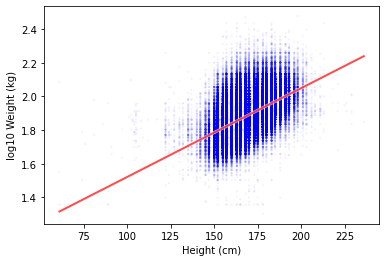

In [237]:
thinkplot.Scatter(heights, log_weights, color='blue', alpha=0.05, s=5)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='log10 Weight (kg)',
                 legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

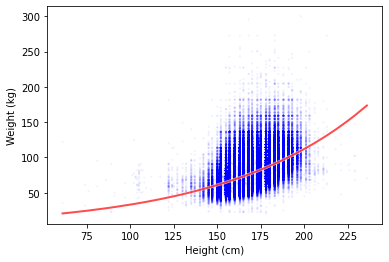

In [238]:
thinkplot.Scatter(heights, weights, color='blue', alpha=0.05, s=5)
thinkplot.Plot(fit_xs, 10**fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, 10**fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Weight (kg)',
                 legend=False)

Plot percentiles of the residuals.

In [239]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [240]:
df['residual'] = Residuals(heights, log_weights, inter, slope)
residual = df['residual']

In [241]:
bins = np.arange(120, 230, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

ht_means = [group.htm3.mean() for _, group in groups][1:-1]
ht_means

[122.48076923076923,
 126.78378378378379,
 130.8842105263158,
 135.78508771929825,
 141.43396226415095,
 146.33718778908417,
 151.52843968228584,
 156.3503419942746,
 161.67421045177736,
 166.56972746679975,
 171.40954232482787,
 176.54908086026674,
 181.57596142807944,
 186.32469990536435,
 191.7859712230216,
 196.6426561620709,
 201.73827160493826,
 206.64864864864865,
 211.51282051282053,
 218.0,
 221.0]

In [242]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

In [243]:
def PlotPercentiles(ht_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        ys = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ht_means, ys, label=label)

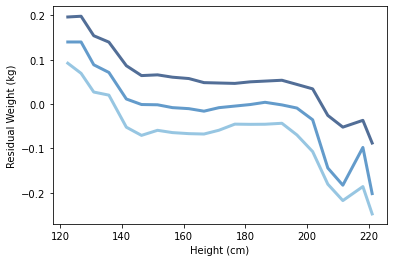

In [244]:
PlotPercentiles(ht_means, cdfs)

thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Residual Weight (kg)')

Compute correlation.

In [245]:
rho = thinkstats2.Corr(heights, log_weights)
print("Correlation:\t", rho)

Correlation:	 0.5317282605983464


Compute coefficient of determination.

In [246]:
r2 = thinkstats2.CoefDetermination(log_weights, residual)
print("Coefficient of Determination:\t", r2)

Coefficient of Determination:	 0.2827349431189352


Confirm that $R^2 = \rho^2$.

In [247]:
print("R squared:\t", r2)
print("p squared:\t", rho**2)

R squared:	 0.2827349431189352
p squared:	 0.28273494311894304


Compute Std(ys), which is the RMSE of predictions that don't use height.

In [248]:
std_ys = thinkstats2.Std(log_weights)
print("Std(ys):\t", std_ys)

Std(ys):	 0.10320725030004853


Compute Std(res), the RMSE of predictions that do use height.

In [249]:
std_res = thinkstats2.Std(residual)
print("Std(res):\t", std_res)

Std(res):	 0.08740777080416083


How much does height information reduce RMSE?

In [250]:
reduce_RMSE = 1 - std_res / std_ys
print("Height information reduces RMSE by:\t", reduce_RMSE)

Height information reduces RMSE by:	 0.1530849765879313


Use resampling to compute sampling distributions for inter and slope.

In [251]:
t = []
for _ in range(500):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

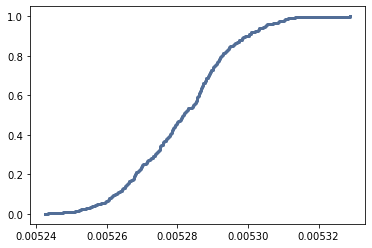

In [252]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [253]:
pvalue = cdf[0]
print("Slope p-value:\t", pvalue)

Slope p-value:	 0


Compute the 90% confidence interval of slope.

In [254]:
ci = cdf.Percentile(5), cdf.Percentile(95)
print("90% Confidence Interval:", ci)

90% Confidence Interval: (0.005257875948392311, 0.005304838326026975)


Compute the mean of the sampling distribution.

In [255]:
mean = thinkstats2.Mean(slopes)
print("Mean of sampling distribution:\t", mean)

Mean of sampling distribution:	 0.005281259573206233


Compute the standard deviation of the sampling distribution, which is the standard error.

In [256]:
stderr = thinkstats2.Std(slopes)
print("Std Dev of sampling distribution:", stderr)

Std Dev of sampling distribution: 1.4211192945167694e-05


Resample rows without weights, compute mean height, and summarize results.

In [257]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

In [258]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print("Mean:\t", mean)
    print("SE:\t", stderr)
    print("CI:\t", ci)

In [259]:
est_no_weight = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]

In [260]:
Summarize(est_no_weight)

Mean:	 168.9528117231553
SE:	 0.014430242214110696
CI:	 (168.92959134178136, 168.97832413751289)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [261]:
def ResampleRowsWeighted(df, column='finalwt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [262]:
est_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]

In [263]:
Summarize(est_weighted)

Mean:	 170.4963879373067
SE:	 0.016441046211176275
CI:	 (170.47157885163404, 170.52081438590108)


How much does correct weighting affect the estimates?

The weighted sampling has a slight effect on height estimates. The difference in means is 1.54 cm, which is well beyond the standard error of ~0.01.

**Exercise:** In Section 9.3, we simulated the null hypothesis by permutation; that is, we treated the observed values as if they represented the entire population, and randomly assigned the members of the population to the two groups.

An alternative is to use the sample to estimate the distribution for the population, then draw a random sample from that distribution. This process is called resampling. There are several ways to implement resampling, but one of the simplest is to draw a sample with replacement from the observed values, as in Section 9.10.

Write a class named `DiffMeansResample` that inherits from `DiffMeansPermute` and overrides `RunModel` to implement resampling, rather than permutation.

Use this model to test the differences in pregnancy length and birth weight. How much does the model affect the results?

In [264]:
# Solution goes here